---
**License**

 NC_CCL_Watson

 Tue Feb 15 12:00:00 2022\
 Copyright  2022\
 Cinthia Nunes de Lima <cinthia.n.lima@uel.br> \ Mariana Penna-Lima <pennalima@gmail.com>

---
---

 NC_CCL_Bocquet_Test\
 Copyright (C) 2022 Cinthia Nunes de Lima <cinthia.n.lima@uel.br>, Mariana Penna-Lima <pennalima@gmail.com>

 numcosmo is free software: you can redistribute it and/or modify it
 under the terms of the GNU General Public License as published by the
 Free Software Foundation, either version 3 of the License, or
 (at your option) any later version.

 numcosmo is distributed in the hope that it will be useful, but
 WITHOUT ANY WARRANTY; without even the implied warranty of
 MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
 See the GNU General Public License for more details.

 You should have received a copy of the GNU General Public License along
 with this program.  If not, see <http://www.gnu.org/licenses/>.
 
---

In [1]:
1# NumCosmo
try:
  import gi
  gi.require_version('NumCosmo', '1.0')
  gi.require_version('NumCosmoMath', '1.0')
except:
  pass

from gi.repository import GObject
from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm

# CCL
import pyccl as ccl
from pyccl.halos.massdef import MassDef

import sys 
import numpy as np 
import math 
import matplotlib.pyplot as plt

%matplotlib inline
import random

In [2]:
Omega_c = 0.262 
Omega_b = 0.049 
Omega_k = 0.0 
H0      = 67.66  
Tcmb0   = 2.7255 
A_s     = 2.1e-9 
sigma8  = 0.8277 
n_s     = 0.96 
Neff    = 3.046
w0      = -1.0 
wa      = 0.0

In [3]:
# CCL Cosmology
cosmo_ccl = ccl.Cosmology(Omega_c=Omega_c, Omega_b=Omega_b, Neff=Neff,
                          h=H0/100.0, n_s=n_s, sigma8=sigma8, Omega_k=Omega_k,
                          w0=w0, wa=wa, T_CMB=Tcmb0, m_nu=[0.00, 0.0, 0.0], 
                          transfer_function='eisenstein_hu', matter_power_spectrum='linear')

Ncm.cfg_init () 
Ncm.cfg_set_log_handler (lambda msg: sys.stdout.write (msg) and sys.stdout.flush ())

# NumCosmo Cosmology
cosmo = Nc.HICosmo.new_from_name (Nc.HICosmo, "NcHICosmoDECpl{'massnu-length':<0>}")
cosmo.omega_x2omega_k ()
cosmo.param_set_by_name ("H0",        H0)
cosmo.param_set_by_name ("Omegak",    Omega_k)
cosmo.param_set_by_name ("w0",        w0)
cosmo.param_set_by_name ("w1",        wa)
cosmo.param_set_by_name ("Omegab",    Omega_b)
cosmo.param_set_by_name ("Omegac",    Omega_c)
cosmo.param_set_by_name ("Tgamma0",   Tcmb0)

hiprim = Nc.HIPrimPowerLaw.new ()
hiprim.param_set_by_name ("ln10e10ASA", math.log (1.0e10 * A_s))
hiprim.param_set_by_name ("n_SA",       n_s)

cosmo.add_submodel (hiprim)
    
dist = Nc.Distance.new (3.0)
dist.prepare (cosmo)


In [4]:
tf = Nc.TransferFunc.new_from_name ("NcTransferFuncEH")

#
# New linear matter power spectrum object based of the EH transfer function.
psml = Nc.PowspecMLTransfer.new (tf)
psml.require_kmin (1.0e-3)
psml.require_kmax (1.0e3)

#
# Apply a tophat filter to the psml object, set best output interval.
psf = Ncm.PowspecFilter.new (psml, Ncm.PowspecFilterType.TOPHAT)
psf.set_best_lnr0 ()

old_amplitude = math.exp (hiprim.props.ln10e10ASA)
hiprim.props.ln10e10ASA = math.log ((sigma8 / cosmo.sigma8(psf))**2 * old_amplitude)
print(sigma8, cosmo.sigma8(psf)) 


0.8277 0.8277


In [5]:
#CCL

ccl_mw_200m = MassDef (Delta = 200, rho_type = "matter")
ccl_200m = ccl.halos.MassFuncWatson13(cosmo_ccl, mass_def = ccl_mw_200m)

ccl_mw_178m = MassDef (Delta = 178, rho_type = "matter")
ccl_178m = ccl.halos.MassFuncWatson13(cosmo_ccl, mass_def = ccl_mw_178m)

ccl_mw_500m = MassDef (Delta = 500, rho_type = "matter")
ccl_500m = ccl.halos.MassFuncWatson13(cosmo_ccl, mass_def = ccl_mw_500m)

ccl_mw_fof = MassDef (Delta = 'fof', rho_type = 'matter')
ccl_fof = ccl.halos.MassFuncWatson13(cosmo_ccl, mass_def = ccl_mw_fof)

# NumCosmo Watson multiplicity function

nc_mfw = Nc.MultiplicityFuncWatson.new ()
nc_mfw.set_mdef (Nc.MultiplicityFuncMassDef.MEAN)
nc_mfw.set_Delta (200.0)
nc_200m = Nc.HaloMassFunction.new (dist, psf, nc_mfw)

nc_mfw = Nc.MultiplicityFuncWatson.new ()
nc_mfw.set_mdef (Nc.MultiplicityFuncMassDef.MEAN)
nc_mfw.set_Delta (178.0)
nc_178m = Nc.HaloMassFunction.new (dist, psf, nc_mfw)

nc_mfw = Nc.MultiplicityFuncWatson.new ()
nc_mfw.set_mdef (Nc.MultiplicityFuncMassDef.MEAN)
nc_mfw.set_Delta (500.0)
nc_500m = Nc.HaloMassFunction.new (dist, psf, nc_mfw)

nc_mfw = Nc.MultiplicityFuncWatson.new ()
nc_mfw.set_mdef (Nc.MultiplicityFuncMassDef.FOF)
nc_fof = Nc.HaloMassFunction.new (dist, psf, nc_mfw)


In [6]:
# Array of masses
m_arr = np.geomspace(1E12,1E15,128)

# Array of redshifts
z_arr = np.linspace(0.0,1.0,16)

In [7]:
psf.prepare (cosmo)
sigma8_nc = psf.eval_sigma (0.0, 8.0 / 0.6766)

nc_200m.set_eval_limits (cosmo, math.log (1e10), math.log(1e16), 0.0, 2.0)
nc_200m.prepare (cosmo)

In [8]:
def cmp_double (desc, m1, m2, x1, x2):
    print ("%s: %s = % 22.15g, %s = % 22.15g, CMP: %9.2e" % (desc, m1, x1, m2, x2, math.fabs (x1 / x2 - 1.0)))

<Figure size 432x288 with 0 Axes>

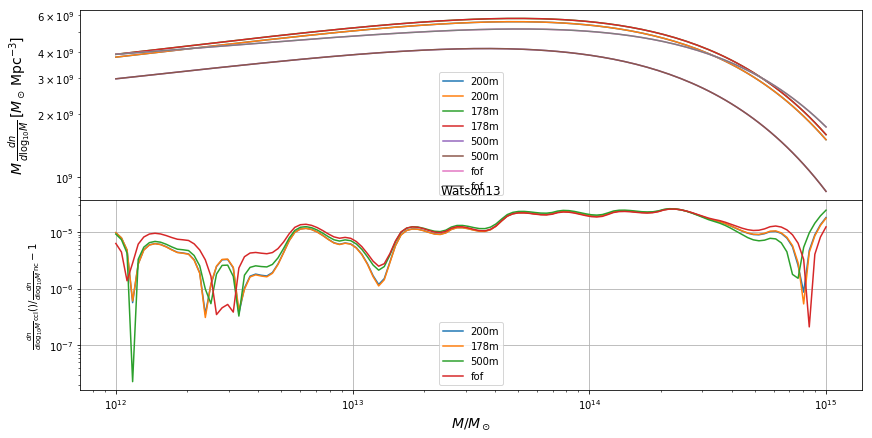

In [9]:
plt.figure()
fig, axs = plt.subplots (2, sharex=True, gridspec_kw={'hspace': 0}, figsize=(14,7))

z = 0.0
a = 1.0 / (1.0 + z)
                        
multiplicity_functions = [(ccl_200m, nc_200m, '200m'),
                          (ccl_178m, nc_178m, '178m'),
                          (ccl_500m, nc_500m, '500m'),
                          (ccl_fof, nc_fof, 'fof')]
                          
#CCL
for ccl_mf_obj, nc_mf_obj, obj_name, in multiplicity_functions:
    ccl_mf = ccl_mf_obj.get_mass_function (cosmo_ccl, m_arr, a)
    ccl_nm = m_arr * ccl_mf
    
    axs[0].plot(m_arr, ccl_nm, label = obj_name)

#NumCosmo    
    nc_mf = [nc_mf_obj.dn_dlnM (cosmo, logm, z) * math.log(10.0) for logm in np.log(m_arr)]
    nc_nm = m_arr * nc_mf
    
    axs[1].plot (m_arr, np.abs (ccl_nm / nc_nm  - 1.0), '-', label = obj_name)
    
    axs[0].plot(m_arr, nc_nm, label = obj_name)

#Plot settings

axs[0].set_xscale ('log')
axs[0].set_yscale ('log')
#axs[0].ylim([1.0E9,8.5E9])
axs[1].set_yscale ('log')
axs[1].set_xlabel(r'$M/M_\odot$', fontsize=14)
axs[0].set_ylabel(r'$M\,\frac{dn}{d\log_{10}M}\,[M_\odot\,{\rm Mpc}^{-3}]$',
           fontsize=14)
axs[1].set_ylabel(r'$\frac{dn}{d\log_{10}M}_{\mathrm{ccl}} () / \frac{dn}{d\log_{10}M}_{\mathrm{nc}} - 1$')
axs[0].legend(loc='best')

axs[1].legend(loc='best')
axs[1].grid()

plt.title('Watson13')
plt.show ()

In [10]:
%timeit ccl_mf_obj.get_mass_function (cosmo_ccl, m_arr, a)

1000 loops, best of 5: 144 µs per loop


In [11]:
%timeit [nc_mf_obj.dn_dlnM (cosmo, logm, z) * math.log(10.0) for logm in np.log(m_arr)]

The slowest run took 11.83 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 5: 386 µs per loop


<Figure size 432x288 with 0 Axes>

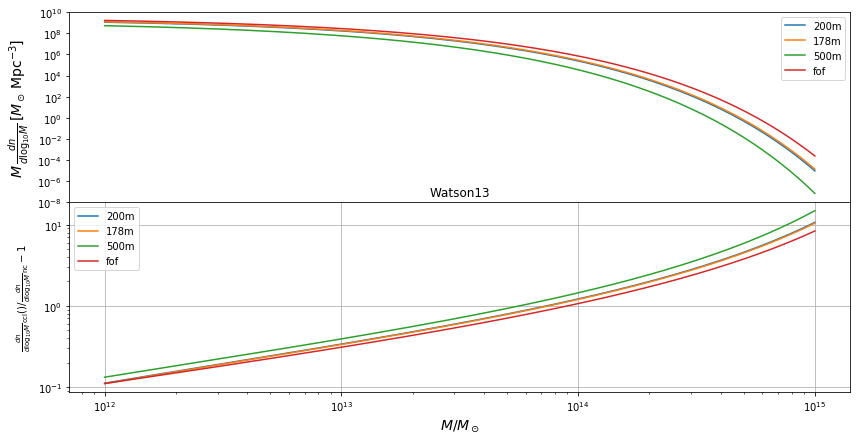

In [13]:
plt.figure()
fig, axs = plt.subplots (2, sharex=True, gridspec_kw={'hspace': 0}, figsize=(14,7))

z = 3.0
a = 1.0 / (1.0 + z)

#CCL
for ccl_mf_obj, nc_mf_obj, obj_name, in multiplicity_functions:
    ccl_mf = ccl_mf_obj.get_mass_function (cosmo_ccl, m_arr, a)
    ccl_nm = m_arr * ccl_mf
    
#  axs[0].plot(m_arr, ccl_nm, label = obj_name)

#NumCosmo    
    nc_mf = [nc_mf_obj.dn_dlnM (cosmo, logm, z) * math.log(10.0) for logm in np.log(m_arr)]
    nc_nm = m_arr * nc_mf
    
    axs[1].plot (m_arr, np.abs (ccl_nm / nc_nm  - 1.0), '-', label = obj_name)
    
    axs[0].plot(m_arr, nc_nm, label = obj_name)

#Plot settings

axs[0].set_xscale ('log')
axs[0].set_yscale ('log')
#axs[0].ylim([1.0E9,8.5E9])
axs[1].set_yscale ('log')
axs[1].set_xlabel(r'$M/M_\odot$', fontsize=14)
axs[0].set_ylabel(r'$M\,\frac{dn}{d\log_{10}M}\,[M_\odot\,{\rm Mpc}^{-3}]$',
           fontsize=14)
axs[1].set_ylabel(r'$\frac{dn}{d\log_{10}M}_{\mathrm{ccl}} () / \frac{dn}{d\log_{10}M}_{\mathrm{nc}} - 1$')
axs[0].legend(loc='best')

axs[1].legend(loc='best')
axs[1].grid()

plt.title('Watson13')
plt.show ()